In [30]:
import numpy as np
import pandas as pd
import math
from fancyimpute import KNN
import matplotlib.pyplot as plt

## Build a clean dataset

### Load and Merge Tables

In [32]:
#### TO RU THIS NOTEBOOK YOU NEED TOREQUEST ACCESS TO DATA: https://tu2019.dk/

#load the files 
household = 'Data/household.csv'
session = 'Data/session.csv'
car = 'Data/bil.csv'
#handpicked columns
cols_session = ['SessionId', 'HomeAdrNUTS', 'HomeAdrMunCode', 
                #'HomeAdrCityCode',
            #'HomeAdrCitySize', 
                'HomeParkPoss', 'RespSex',
                'RespYearBorn', 'RespAgeCorrect', 'RespEdulevel', 'RespPrimOcc',
                'PrimOccMuncode', 'WorkHoursPw', 'WorkHourType',
                'WorkPubPriv', 'WorkatHomeDayspM', 'GISdistHW',
                'HwDayspW', 'WorkParkPoss', 'RespHasBicycle',
                'RespHasSeasonticket', 'RespHasRejsekort',
                'ResphasDrivlic', 'RespDrivlicYear', 'HousehNumcars',
                'HousehCarOwnership', 'HousehCarOwnership', 'Handicap',
                'HousehAccomodation', 'HousehAccOwnorRent', 'IncRespondent',
                'IncSpouse', 'IncNuclFamily', 'IncFamily', 'IncHouseh',
                'NuclFamType', 'PosInFamily', 'NuclFamNumPers',
                'NuclFamNumAdults', 'NuclFamNumPers1084', 'NuclFamNumPersO6',
                'NuclFamNumDrivLic', 'FamNumPers', 'FamNumAdults', 'FamNumPers1084', 'FamNumPersO6',
                'FamNumDrivLic', 'HousehNumPers', 'HousehNumAdults',
                'HousehNumPers1084', 'HousehNumPersO6', 'HousehNumDrivLic','NightsAway']
cols_car = ['sessionid', 'bilnr', 'ModelYear', 'FuelType' ]
cols_household = ['SessionId', 'Relation']
df_session = pd.read_csv(session,sep=';', index_col='SessionId', usecols=cols_session,
                         error_bad_lines=False, warn_bad_lines=True, low_memory=False)
df_car = pd.read_csv(car,sep=';', index_col='sessionid', usecols=cols_car,
                     dtype={'bilnr': np.int32},
                     error_bad_lines=False, warn_bad_lines=True, low_memory=False)
df_car.rename({'sessionid': 'SessionId'})
df_household = pd.read_csv(household,sep=';', index_col='SessionId', usecols=cols_household,
                         error_bad_lines=False, warn_bad_lines=True, low_memory=False)

In [33]:
#joined table
df_joined = df_session
#df_joined = df_joined.join(df_household, on='SessionId', how='left')
#df_joined = df_joined.join(df_car, on='SessionId', how='left')
all_cols = set(list(df_joined.columns))
#len(all_cols)
df_infer = df_joined
print('Original Size:', len(df_infer.index))

Original Size: 167499


###  Manual Inference of Values

In [34]:
#if does not have driving lic then fill in the year
for row in df_joined.loc[df_joined['RespDrivlicYear'].isna()].iterrows():
    indx = row[0]
    rec = row[1]
    if rec['ResphasDrivlic'] not in [1,3]:
        df_infer.loc[indx, 'RespDrivlicYear'] = -1
#if person does not have a spouse then income is 0

#for row in df_joined.loc[df_joined['IncSpouse'].isna()].iterrows():
#    indx = row[0]
#    rec = row[1]
#    if rec['NuclFamType'] not in [20,21]:
#        df_infer.loc[indx, 'IncSpouse'] = 0
        

### Dropping Columns

In [35]:
#Remove Columns that have more than 20% of missing values 
nan_treshold = 0.20
cols_infer = (df_infer.isnull().sum()/len(df_infer.index))
cols_infer = cols_infer.where(cols_infer < nan_treshold)
cols_infer = list(cols_infer.dropna().index)
df_infer = df_infer[cols_infer]
len(df_infer.index)

167499

In [36]:
print('Kept columns:' , len(df_infer.columns), 'out of', len(df_joined.columns))
print( [v for v in df_infer.columns])

Kept columns: 33 out of 49
['HomeAdrNUTS', 'HomeAdrMunCode', 'RespSex', 'RespYearBorn', 'RespAgeCorrect', 'RespPrimOcc', 'RespEdulevel', 'RespHasBicycle', 'RespHasSeasonticket', 'ResphasDrivlic', 'RespDrivlicYear', 'HousehNumcars', 'HousehCarOwnership', 'Handicap', 'HousehAccomodation', 'HousehAccOwnorRent', 'NuclFamType', 'PosInFamily', 'NuclFamNumPers', 'NuclFamNumAdults', 'NuclFamNumPers1084', 'NuclFamNumPersO6', 'NuclFamNumDrivLic', 'FamNumPers', 'FamNumAdults', 'FamNumPers1084', 'FamNumPersO6', 'FamNumDrivLic', 'HousehNumPers', 'HousehNumAdults', 'HousehNumPers1084', 'HousehNumPersO6', 'HousehNumDrivLic']


## Categorical Data 

In [40]:
categorical = ['HomeAdrNUTS', 'HomeAdrMunCode',  'RespSex', 'RespPrimOcc', 'RespEdulevel', 'RespHasBicycle',
              'RespHasSeasonticket', 'ResphasDrivlic', 'Handicap', 'HousehAccomodation', 'PosInFamily', 'NuclFamType',
              'HousehAccOwnorRent']
numerical = ['RespYearBorn', 'RespAgeCorrect', 'RespDrivlicYear', 'HousehNumcars', 
             #'IncRespondent',
            'NuclFamNumPers', 'NuclFamNumAdults', 'NuclFamNumPers1084',
             'NuclFamNumPersO6', 'NuclFamNumDrivLic', 'FamNumPers', 'FamNumAdults',
             'FamNumPers1084', 'FamNumPersO6', 'FamNumDrivLic', 'HousehNumPers',
             'HousehNumAdults', 'HousehNumPers1084', 'HousehNumPersO6',
             'HousehNumDrivLic']

df_infer[categorical] = df_infer[categorical].astype('category')
df_infer[categorical].describe().append(df_infer[categorical].isnull().sum().rename('isnull'))


,HomeAdrNUTS,HomeAdrMunCode,RespSex,RespPrimOcc,RespEdulevel,RespHasBicycle,RespHasSeasonticket,ResphasDrivlic,Handicap,HousehAccomodation,PosInFamily,NuclFamType,HousehAccOwnorRent
count,167264,167264,167264,165802.0,167195.0,167263.0,167264,167258.0,167263.0,167264.0,167264.0,167264.0,167241.0
unique,11,99,2,18.0,11.0,2.0,2,4.0,2.0,6.0,4.0,4.0,3.0
top,DK042,101,2,210.0,11.0,1.0,2,1.0,2.0,1.0,12.0,21.0,1.0
freq,25077,13932,85845,74903.0,37035.0,119457.0,141612,125163.0,157192.0,92525.0,50963.0,69049.0,118238.0
isnull,0,0,0,1462.0,69.0,1.0,0,6.0,1.0,0.0,0.0,0.0,23.0


In [41]:
#drop records/rows with little amount of NAN values + hard to infer
to_drop = ['PosInFamily', 'HousehAccomodation']
df_infer = df_infer.dropna(subset= to_drop, how='any')
df_infer[categorical].describe().append(df_infer[categorical].isnull().sum().rename('isnull'))

,HomeAdrNUTS,HomeAdrMunCode,RespSex,RespPrimOcc,RespEdulevel,RespHasBicycle,RespHasSeasonticket,ResphasDrivlic,Handicap,HousehAccomodation,PosInFamily,NuclFamType,HousehAccOwnorRent
count,167264,167264,167264,165802.0,167195.0,167263.0,167264,167258.0,167263.0,167264.0,167264.0,167264.0,167241.0
unique,11,99,2,18.0,11.0,2.0,2,4.0,2.0,6.0,4.0,4.0,3.0
top,DK042,101,2,210.0,11.0,1.0,2,1.0,2.0,1.0,12.0,21.0,1.0
freq,25077,13932,85845,74903.0,37035.0,119457.0,141612,125163.0,157192.0,92525.0,50963.0,69049.0,118238.0
isnull,0,0,0,1462.0,69.0,1.0,0,6.0,1.0,0.0,0.0,0.0,23.0


In [42]:
df_infer[numerical].describe().append(df_infer[numerical].isnull().sum().rename('isnull'))

,RespYearBorn,RespAgeCorrect,RespDrivlicYear,HousehNumcars,NuclFamNumPers,NuclFamNumAdults,NuclFamNumPers1084,NuclFamNumPersO6,NuclFamNumDrivLic,FamNumPers,FamNumAdults,FamNumPers1084,FamNumPersO6,FamNumDrivLic,HousehNumPers,HousehNumAdults,HousehNumPers1084,HousehNumPersO6,HousehNumDrivLic
count,167264.000000,167264.000000,167217.000000,167249.000000,167227.000000,167227.000000,167227.000000,167227.000000,167227.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,166665.000000,166665.000000,166665.000000,166665.000000
mean,1967.178377,43.937661,1529.566037,1.197777,2.683382,1.922602,2.379155,2.535296,1.693303,2.744255,1.972439,2.436657,2.594707,1.732728,2.785937,2.001722,2.471461,2.628104,1.755768
std,20.689355,20.332919,832.821875,0.793144,1.320889,0.663838,1.117622,1.226656,0.742981,1.336917,0.699659,1.141389,1.245437,0.764680,1.349104,0.707694,1.151338,1.249497,0.768809
min,1914.000000,6.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,1950.000000,27.000000,1954.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000
50%,1966.000000,45.000000,1975.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,1985.000000,60.000000,1991.000000,2.000000,4.000000,2.000000,3.000000,3.000000,2.000000,4.000000,2.000000,3.000000,4.000000,2.000000,4.000000,2.000000,3.000000,4.000000,2.000000
max,2013.000000,102.000000,2019.000000,25.000000,14.000000,9.000000,14.000000,14.000000,8.000000,15.000000,11.000000,15.000000,15.000000,10.000000,40.000000,12.000000,20.000000,20.000000,12.000000
isnull,0.000000,0.000000,47.000000,15.000000,37.000000,37.000000,37.000000,37.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,599.000000,599.000000,599.000000,599.000000


## Fancy Impute

In [43]:
from sklearn.preprocessing import LabelEncoder
df_infer = df_infer.replace(to_replace=r'^DK', value='', regex=True)
#df_infer.to_pickle('TU_infered')

In [44]:
r = range(0, len(df_infer.index), 20000)
df_final = df_infer
for i in r:
    try:
        df_final.iloc[i:i+20000] = KNN(k=2).fit_transform(df_infer.iloc[i:i+20000])
    except:
        print('Issue at %s' %i)

Imputing row 1/20000 with 0 missing, elapsed time: 80.954
Imputing row 101/20000 with 0 missing, elapsed time: 80.954
Imputing row 201/20000 with 0 missing, elapsed time: 80.955
Imputing row 301/20000 with 0 missing, elapsed time: 80.956
Imputing row 401/20000 with 0 missing, elapsed time: 80.957
Imputing row 501/20000 with 0 missing, elapsed time: 80.957
Imputing row 601/20000 with 0 missing, elapsed time: 80.958
Imputing row 701/20000 with 0 missing, elapsed time: 80.958
Imputing row 801/20000 with 0 missing, elapsed time: 80.959
Imputing row 901/20000 with 0 missing, elapsed time: 80.959
Imputing row 1001/20000 with 0 missing, elapsed time: 80.960
Imputing row 1101/20000 with 0 missing, elapsed time: 80.961
Imputing row 1201/20000 with 0 missing, elapsed time: 80.961
Imputing row 1301/20000 with 0 missing, elapsed time: 80.961
Imputing row 1401/20000 with 0 missing, elapsed time: 80.962
Imputing row 1501/20000 with 0 missing, elapsed time: 80.963
Imputing row 1601/20000 with 0 missi

In [45]:
df_final[numerical].describe().append(df_final[numerical].isnull().sum().rename('isnull'))

,RespYearBorn,RespAgeCorrect,RespDrivlicYear,HousehNumcars,NuclFamNumPers,NuclFamNumAdults,NuclFamNumPers1084,NuclFamNumPersO6,NuclFamNumDrivLic,FamNumPers,FamNumAdults,FamNumPers1084,FamNumPersO6,FamNumDrivLic,HousehNumPers,HousehNumAdults,HousehNumPers1084,HousehNumPersO6,HousehNumDrivLic
count,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000
mean,1967.178377,43.937661,1529.609900,1.197766,2.683439,1.922593,2.379189,2.535348,1.693267,2.744255,1.972439,2.436657,2.594707,1.732728,2.785937,2.000713,2.471403,2.627976,1.754837
std,20.689355,20.332919,832.766272,0.793115,1.320846,0.663816,1.117586,1.226622,0.742967,1.336917,0.699659,1.141389,1.245437,0.764680,1.349104,0.707738,1.150995,1.249126,0.768691
min,1914.000000,6.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,1950.000000,27.000000,1954.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000
50%,1966.000000,45.000000,1975.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,1985.000000,60.000000,1991.000000,2.000000,4.000000,2.000000,3.000000,3.000000,2.000000,4.000000,2.000000,3.000000,4.000000,2.000000,4.000000,2.000000,3.000000,4.000000,2.000000
max,2013.000000,102.000000,2019.000000,25.000000,14.000000,9.000000,14.000000,14.000000,8.000000,15.000000,11.000000,15.000000,15.000000,10.000000,40.000000,12.000000,20.000000,20.000000,12.000000
isnull,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [46]:
df_final[categorical].describe().append(df_final[categorical].isnull().sum().rename('isnull'))

,HomeAdrNUTS,HomeAdrMunCode,RespSex,RespPrimOcc,RespEdulevel,RespHasBicycle,RespHasSeasonticket,ResphasDrivlic,Handicap,HousehAccomodation,PosInFamily,NuclFamType,HousehAccOwnorRent
count,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000,167264.000000
mean,28.964266,475.960924,1.513231,232.319774,8.635800,1.285818,1.846638,-1.506918,1.939790,1.928789,12.759398,17.933560,1.352803
std,13.403469,251.027035,0.499826,89.941631,4.706611,0.451804,0.360338,6.641673,0.237877,1.190426,3.532016,4.510965,0.589815
min,11.000000,101.000000,1.000000,103.000000,1.000000,1.000000,1.000000,-18.000000,1.000000,1.000000,10.000000,10.000000,1.000000
25%,13.000000,240.000000,1.000000,210.000000,4.000000,1.000000,2.000000,1.000000,2.000000,1.000000,11.000000,11.000000,1.000000
50%,31.000000,461.000000,2.000000,210.000000,11.000000,1.000000,2.000000,1.000000,2.000000,1.000000,11.000000,20.000000,1.000000
75%,42.000000,740.000000,2.000000,320.000000,13.000000,2.000000,2.000000,1.000000,2.000000,3.000000,12.000000,21.000000,2.000000
max,50.000000,860.000000,2.000000,390.000013,14.000000,2.000000,2.000000,3.000000,2.000000,6.000000,20.000000,21.000000,3.000000
isnull,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


##### Save the processed data

In [48]:
df_final.to_pickle('TU_imputed')

## KNN Cross Validation
The code below was used to perform cross validation and to debug the errors

In [42]:
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
df_clean = df_infer[numerical].dropna(how='any')
df_clean = pd.DataFrame(normalize(df_clean))
kf = KFold(n_splits=3)
kf.get_n_splits(df_clean)

3

In [420]:
#find optima number of K-neighbours for imputing 
cols_to_predict = [2,3,4,6,15, 17,18]
num_k = 10
acc = np.zeros(shape=[10, len(cols_to_predict)])
for nk,  k_ in enumerate(range(1,10)):
    print('K:', k_)
    for train_index, test_index in kf.split(df_clean):
        for nc, col in enumerate(cols_to_predict):
            y = df_clean[col].values
            X = df_clean.drop(col, axis=1).values
            #print("K:", k_, "Col:", col)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf = KNeighborsRegressor(n_neighbors=k_).fit(X_train, y_train)
            y_hat = clf.predict(X_test)
            err = np.sum(np.sqrt(np.power(y_test-y_hat,2)))/len(y_hat)
            acc[nk, nc] +=err


K: 1
K: 2
K: 3
K: 4
K: 5
K: 6
K: 7
K: 8
K: 9


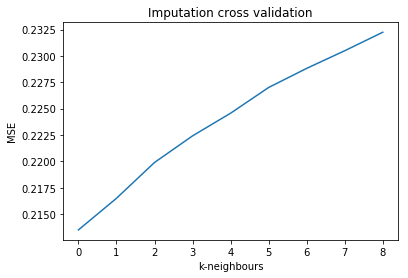

In [433]:
import matplotlib.pyplot as plt
acc_ = normalize(acc)
plt.plot(np.mean(acc_[:-1], axis=1))
plt.ylabel('MSE')
plt.xlabel('k-neighbours')
plt.title('Imputation cross validation')
plt.show()

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
df_clean = df_infer[categorical].dropna(how='any')
kf = KFold(n_splits=3)
kf.get_n_splits(df_clean)
#find optima number of K-neighbours for imputing 
num_k = 5
acc = np.zeros(shape=[num_k, len(categorical)])
cols_of_interest = ['RespPrimOcc', 'RespEdulevel', 'ResphasDrivlic']

for col in categorical:
    df_clean[col] = LabelEncoder.fit_transform(df_clean[col], df_clean[col])

In [ ]:
for nk,  k_ in enumerate(range(1,6)):
    print('K:', k_)
    for train_index, test_index in kf.split(df_clean):
        for nc, col in enumerate(cols_of_interest):
            y = df_clean[col].values
            X = df_clean.drop(col, axis=1).values
            #print("K:", k_, "Col:", col)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf = KNeighborsClassifier(n_neighbors=k_).fit(X_train, y_train)
            y_hat = clf.predict(X_test)
            err = np.sum(np.where(y_hat==y_test))/len(y_hat)
            acc[nk, nc] +=err

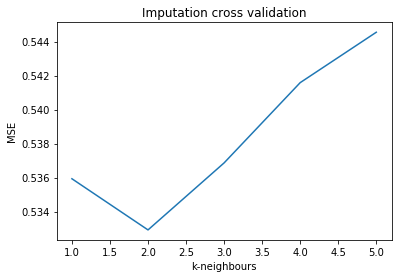

In [46]:
import matplotlib.pyplot as plt

acc_ = normalize(acc[:,:3])
plt.plot([1,2,3,4,5], np.mean(acc_, axis=1))
plt.ylabel('MSE')
plt.xlabel('k-neighbours')
plt.title('Imputation cross validation')
plt.show()

In [329]:
numerical = ['RespYearBorn', 'RespAgeCorrect', 'RespDrivlicYear', 'HousehNumcars', 
             #'IncRespondent',
            'NuclFamNumPers', 'NuclFamNumAdults', 'NuclFamNumPers1084',
             'NuclFamNumPersO6', 'NuclFamNumDrivLic', 'FamNumPers', 'FamNumAdults',
             'FamNumPers1084', 'FamNumPersO6', 'FamNumDrivLic', 'HousehNumPers',
             'HousehNumAdults', 'HousehNumPers1084', 'HousehNumPersO6',
             'HousehNumDrivLic']
df_infer[numerical].describe().append(df_infer[numerical].isnull().sum().rename('isnull'))

,RespYearBorn,RespAgeCorrect,RespDrivlicYear,HousehNumcars,IncRespondent,NuclFamNumPers,NuclFamNumAdults,NuclFamNumPers1084,NuclFamNumPersO6,NuclFamNumDrivLic,FamNumPers,FamNumAdults,FamNumPers1084,FamNumPersO6,FamNumDrivLic,HousehNumPers,HousehNumAdults,HousehNumPers1084,HousehNumPersO6,HousehNumDrivLic
count,167450.000000,167450.000000,167403.000000,167432.000000,122414.000000,167412.000000,167412.000000,167412.000000,167412.000000,167412.000000,167450.000000,167450.000000,167450.000000,167450.000000,167450.000000,167450.000000,166822.000000,166822.000000,166822.000000,166822.000000
mean,1967.179027,43.938579,1529.560462,1.197913,266.159042,2.682944,1.922401,2.378898,2.534944,1.692770,2.743912,1.972266,2.436489,2.594452,1.732165,2.786032,2.001708,2.471455,2.628035,1.755356
std,20.689737,20.333208,832.826188,0.793090,437.289856,1.320726,0.663982,1.117500,1.226485,0.743148,1.336848,0.699860,1.141404,1.245375,0.764842,1.349228,0.707827,1.151372,1.249446,0.768930
min,1914.000000,6.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,1950.000000,27.000000,1954.000000,1.000000,120.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000
50%,1966.000000,45.000000,1975.000000,1.000000,250.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,1985.000000,60.000000,1991.000000,2.000000,360.000000,4.000000,2.000000,3.000000,3.000000,2.000000,4.000000,2.000000,3.000000,4.000000,2.000000,4.000000,2.000000,3.000000,4.000000,2.000000
max,2013.000000,102.000000,2019.000000,25.000000,80000.000000,14.000000,9.000000,14.000000,14.000000,8.000000,15.000000,11.000000,15.000000,15.000000,10.000000,40.000000,12.000000,20.000000,20.000000,12.000000
isnull,0.000000,0.000000,47.000000,18.000000,45036.000000,38.000000,38.000000,38.000000,38.000000,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,628.000000,628.000000,628.000000,628.000000


In [340]:
df_temp = df_infer[numerical]
df_temp = pd.DataFrame(KNN.)
#(np.abs(df_temp.corr()) > 0.95)

,RespYearBorn,RespAgeCorrect,RespDrivlicYear,HousehNumcars,IncRespondent,NuclFamNumPers,NuclFamNumAdults,NuclFamNumPers1084,NuclFamNumPersO6,NuclFamNumDrivLic,FamNumPers,FamNumAdults,FamNumPers1084,FamNumPersO6,FamNumDrivLic,HousehNumPers,HousehNumAdults,HousehNumPers1084,HousehNumPersO6,HousehNumDrivLic
RespYearBorn,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
RespAgeCorrect,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
RespDrivlicYear,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
HousehNumcars,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
IncRespondent,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
NuclFamNumPers,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False
NuclFamNumAdults,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
NuclFamNumPers1084,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False
NuclFamNumPersO6,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False
NuclFamNumDrivLic,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [ ]:
#Drop columns based on the correlation

In [67]:
#Final table
df_nan = df_infer.isna()
df_simple_impute = df_infer.fillna(df_infer.median())
filtered_cols = set(list(df_simple_impute.columns))
all_cols.difference(filtered_cols)

{'GISdistHW',
 'HomeParkPoss',
 'HwDayspW',
 'IncFamily',
 'IncHouseh',
 'IncNuclFamily',
 'IncSpouse',
 'NightsAway',
 'PrimOccMuncode',
 'RespHasRejsekort',
 'WorkHourType',
 'WorkHoursPw',
 'WorkParkPoss',
 'WorkPubPriv',
 'WorkatHomeDayspM'}

## Not used

In [4]:
for row in df_joined.iterrows():
    indx = row[0]
    rec = row[1]
    ## if does not have a driving license, then -1 License year
    if rec['ResphasDrivlic'] not in [1,3] and math.isnan(rec['RespDrivlicYear']):
        rec['RespDrivlicYear'] = -1
    ## if not family then 
    if(rec['NuclFamType'] not in [20,21] and math.isnan(rec['IncSpouse'])):
        rec['IncSpouse'] = 0    
    df_to_process.iloc[indx] = rec
    
## try to filter by condition and set values to -1 or 0 


NameError: name 'df_to_process' is not defined

In [93]:
cols_car = (df_car.isnull().sum()/len(df_car.index))
cols_car = cols_car.where(cols_car < nan_treshold)
cols_car = list(cols_car.dropna().index)
#cols_car

In [94]:
cols_household = (df_household.isnull().sum()/len(df_household.index))
cols_household = cols_household.where(cols_household < nan_treshold)
cols_household = list(cols_household.dropna().index)
#cols_household

In [95]:
cols_session = (df_session.isnull().sum()/len(df_session.index))
cols_session = cols_session.where(cols_session < nan_treshold)
cols_session = list(cols_session.dropna().index)
#cols_session

In [96]:
df_car_ = df_car[cols_car]
df_household_ = df_household[cols_household]
df_session_ = df_session[cols_session]